### Natalia Marko, project, part 3, production
    3. Deployment of the Model in Production
    3.1 Create a new model, load the weights.
    3.2 Use the new model to calculate labels and accuracy for the validation dataset.


In [35]:
# Continue with regular imports
import torch, torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
from torchinfo import summary
from torchvision import datasets, transforms
import torch
import torchvision.models as models
from torch.utils.data import DataLoader
from torchmetrics import ConfusionMatrix, Precision, Recall, F1Score, Accuracy
import matplotlib.pyplot as plt
from torchmetrics import 

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [7]:
old_model_weights_path = "/Users/nataliamarko/Documents/BIG_DATA_LAB_DATA/Image_classification/model_transf_learn_convnet50/Marko_NN_model_transf_learn_convnet50.pt"

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the new model with the same architecture
new_model = models.resnet50(weights=None).to(device)

# Replace the classifier with the same architecture used during training
new_model.fc = torch.nn.Linear(in_features=2048, out_features=2, bias=True).to(device)

# Load the saved state_dict
state_dict = torch.load(old_model_weights_path, map_location=device)
new_model.load_state_dict(state_dict)

# Verify the layers
for name, param in new_model.named_parameters():
    print(f"Layer: {name}, Requires Grad: {param.requires_grad}")

Layer: conv1.weight, Requires Grad: True
Layer: bn1.weight, Requires Grad: True
Layer: bn1.bias, Requires Grad: True
Layer: layer1.0.conv1.weight, Requires Grad: True
Layer: layer1.0.bn1.weight, Requires Grad: True
Layer: layer1.0.bn1.bias, Requires Grad: True
Layer: layer1.0.conv2.weight, Requires Grad: True
Layer: layer1.0.bn2.weight, Requires Grad: True
Layer: layer1.0.bn2.bias, Requires Grad: True
Layer: layer1.0.conv3.weight, Requires Grad: True
Layer: layer1.0.bn3.weight, Requires Grad: True
Layer: layer1.0.bn3.bias, Requires Grad: True
Layer: layer1.0.downsample.0.weight, Requires Grad: True
Layer: layer1.0.downsample.1.weight, Requires Grad: True
Layer: layer1.0.downsample.1.bias, Requires Grad: True
Layer: layer1.1.conv1.weight, Requires Grad: True
Layer: layer1.1.bn1.weight, Requires Grad: True
Layer: layer1.1.bn1.bias, Requires Grad: True
Layer: layer1.1.conv2.weight, Requires Grad: True
Layer: layer1.1.bn2.weight, Requires Grad: True
Layer: layer1.1.bn2.bias, Requires Grad:

# Use the new model to calculate labels for the validation dataset.

In [23]:
# Set the path to the data directory
data_path = '/Users/nataliamarko/Documents/BIG_DATA_LAB_DATA/Image_classification/'
image_folder_path = '/Users/nataliamarko/Documents/BIG_DATA_LAB_DATA/Image_classification/plates'

# Write transform for image
transform = transforms.Compose([
    transforms.CenterCrop(256),
    transforms.ToTensor()
])
# Load the dataset for validation(hidden)

valid_data = torchvision.datasets.ImageFolder(root=image_folder_path + '/hidden', transform=transform)

BATCH_SIZE = 1
NUM_WORKERS = 3

valid_dataloader = DataLoader(valid_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS,
                             pin_memory=True)

# Make predictions

In [25]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

y_preds = []
new_model.eval()
with torch.inference_mode():
    for X, y in tqdm(valid_dataloader, desc="Making predictions"):
        # Send data and targets to target device
        X, y = X.to(device), y.to(device)
        # Do the forward pass
        y_logit = new_model(X)
        # Turn predictions from logits -> prediction probabilities -> predictions labels
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
        # Put predictions on CPU for evaluation
        y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/10 [00:00<?, ?it/s]

# Evaluate the model plotting confusion matrix

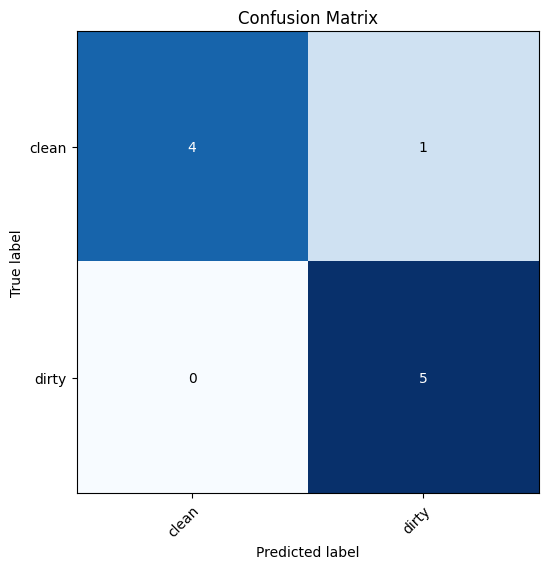

In [27]:
# Get class names as a list
class_names = ['clean', 'dirty']

target_tensor = torch.tensor(valid_data.targets, dtype=torch.long)
if y_pred_tensor.shape != target_tensor.shape:
    raise RuntimeError("Predictions and targets must have the same shape.")

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='binary')
confmat_tensor = confmat(preds=y_pred_tensor, 
                         target=target_tensor)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),  # Convert tensor to NumPy array
    class_names=class_names,
    figsize=(6, 6)
)

# Add title and labels to the plot
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

# Display the plot
plt.show()

# evaluate the model by metrics  Precision, Recall, F1Score, Accuracy

In [29]:
target_tensor = torch.tensor(valid_data.targets, dtype=torch.long)
precision = Precision(num_classes=2, average='binary', task='binary')
recall = Recall(num_classes=2, average='binary', task='binary')
f1 = F1Score(num_classes=2, average='binary', task='binary')
accuracy = Accuracy(num_classes=2, average='binary', task='binary')

precision_val = precision(y_pred_tensor, target_tensor)
recall_val = recall(y_pred_tensor, target_tensor)
f1_val = f1(y_pred_tensor, target_tensor)
accuracy_val = accuracy(y_pred_tensor, target_tensor)

print("Accuracy:", round(accuracy_val.item(), 4))
print("Precision:", round(precision_val.item(), 4))
print("Recall:", round(recall_val.item(), 4))
print("F1 score:", round(f1_val.item(), 4))

Accuracy: 0.9
Precision: 0.8333
Recall: 1.0
F1 score: 0.9091


### I DID IT :)